In [803]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#SARIMA RELATED IMPORTS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import pmdarima as pm

#Evaluation metrics
from sklearn.metrics import mean_squared_error

#Parameter tuning
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

#Models
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor

#import joblib to save models
import joblib

sns.set()

In [694]:
demand=pd.read_csv('../data/processed/load_data.csv',index_col='time',parse_dates=True)

In [695]:
weather=pd.read_csv('../data/processed/weather_new_data.csv',index_col='dt_iso',parse_dates=True)

We will first set up our train and test data. We will train on the years of 2015,2016 and 2017. We will test on data from 2018. We aim to predict the total value of weekly demand.

In [696]:
#aggreagting demand by week
demand_actual=demand['total load actual']
weekly_demand=demand_actual.resample("W").sum()

In [697]:
#setting up train and test datasets
y_train=weekly_demand[weekly_demand.index.year.isin([2015,2016,2017])][1:-1].values
y_test=weekly_demand[weekly_demand.index.year.isin([2018])][1:-1].values

We will create all the features that might be useful to predict demand using the different models and we will reduce them as we understand their importance in the respective models.

In [698]:
#weather features
x1=weather.temp_c.resample("W").mean() #mean temperature
x2=weather.temp_c_max.resample("W").max() #max temperature
x3=weather.temp_c_min.resample("W").min() # min temperature
x4=weather.pressure.resample("W").mean() #mean pressure
x5=weather.humidity.resample("W").mean() # mean humidity
x6=weather.wind_speed.resample("W").max() #max wind speed



#percentage change features
x7=pd.Series(weather.temp_c.resample("W").mean().pct_change().replace([np.inf, -np.inf, np.nan], 0).values,index=x1.index) #pct change of mean temperature
x8=pd.Series(weather.temp_c_max.resample("W").mean().pct_change().replace([np.inf, -np.inf, np.nan], 0).values,index=x1.index) #pct change of max temperature
x9=pd.Series(weather.temp_c_min.resample("W").mean().pct_change().replace([np.inf, -np.inf, np.nan], 0).values,index=x1.index) #pct change of min temperature
x10=pd.Series(weather.pressure.resample("W").mean().pct_change().replace([np.inf, -np.inf, np.nan], 0).values,index=x1.index) #pct change of mean pressure
x11=pd.Series(weather.humidity.resample("W").mean().pct_change().replace([np.inf, -np.inf, np.nan], 0).values,index=x1.index) #pct change of mean humidity
x12=pd.Series(weather.wind_speed.resample("W").max().pct_change().replace([np.inf, -np.inf, np.nan], 0).values,index=x1.index) #pct change of max wind speed

#Datetime features
x13=pd.Series(x1.index.weekofyear.values, index=x1.index, name="week") #week of year
x14=pd.Series(x1.index.month.values, index=x1.index, name='month') #month of year
x15=pd.Series(x1.index.quarter.values, index=x1.index, name='quarter') #quarter of year


In [699]:
#differential variables

#difference in demand(by 1 week) 
x16 = pd.Series(np.append([0],list(np.diff(weekly_demand,n=1))),index=x1.index)

#difference in demand(by 2 week) 
x17 = pd.Series(np.append([0,0],list(np.diff(weekly_demand,n=2))),index=x1.index)

#difference in temperatures(by 1 week) 
x18 = pd.Series(np.append([0],list(np.diff(x1,n=1))),index=x1.index)
x19 = pd.Series(np.append([0],list(np.diff(x2,n=1))),index=x1.index)
x20 = pd.Series(np.append([0],list(np.diff(x3,n=1))),index=x1.index)

In [700]:
X=pd.DataFrame(data=[x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20]).T
X_train=X.loc[X.index.year.isin([2015,2016,2017])][1:-1].values
X_test=X.loc[X.index.year.isin([2018])][1:-1].values

In [701]:
print("The mean total weekly demand between 2015 and 2018 is " + str(np.round(weekly_demand.mean()/10**6,2)) +" million MW.")

The mean total weekly demand between 2015 and 2018 is 4.79 million MW.


We will examine multiple models which include the following:
1. Seasonal ARIMA model
2. Random Forest Regressor
3. Gradient Boost Regressor
4. XG Boost

The models wil be examined using RMSE. 



In [702]:
models=pd.DataFrame({'best_model':['sarimax', 'random_forest','gradient_boost','xg_boost'],
'RMSE_training(MW)':np.NaN,
'RMSE/mean_training(%)':np.NaN,
 'RMSE_testing(MW)':np.NaN,
'RMSE/mean_testing(%)':np.NaN,
}).set_index('best_model')
models

,RMSE_training(MW),RMSE/mean_training(%),RMSE_testing(MW),RMSE/mean_testing(%)
best_model,,,,
sarimax,NaN,NaN,NaN,NaN
random_forest,NaN,NaN,NaN,NaN
gradient_boost,NaN,NaN,NaN,NaN
xg_boost,NaN,NaN,NaN,NaN


At the end of this project, the above table will be filled out to show how the best of each model performs.

Let's start with the Seasonal ARIMA model..

# 1. Seasonal ARIMA Model

Following the Box-Jenkins method, we can choose our parameters...

- Time Series Identifcation
    - Stationary or non stationary?
    - Determing Seasonality
- Parameter Estimation:
    - The AR and MA coefficiants will need to be estimated. This will be done automatically using the .fit() method
    - Orders of MA and AR will need to be estimated. This can be done by looping over orders and comparing the AIC scores.
- Model Diagnostic: 
    - Are the residuals uncorrelated?
    - Are residuals normally distributed?
    - Plotting diagnostic and looking at hypothesis tests?
    - If residuals look good, model can proceed to forecasting.
    - If not, model will need to be optimized.
    

## A) Identification

Let's plot the weekly demand

C:\Users\yfawz\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


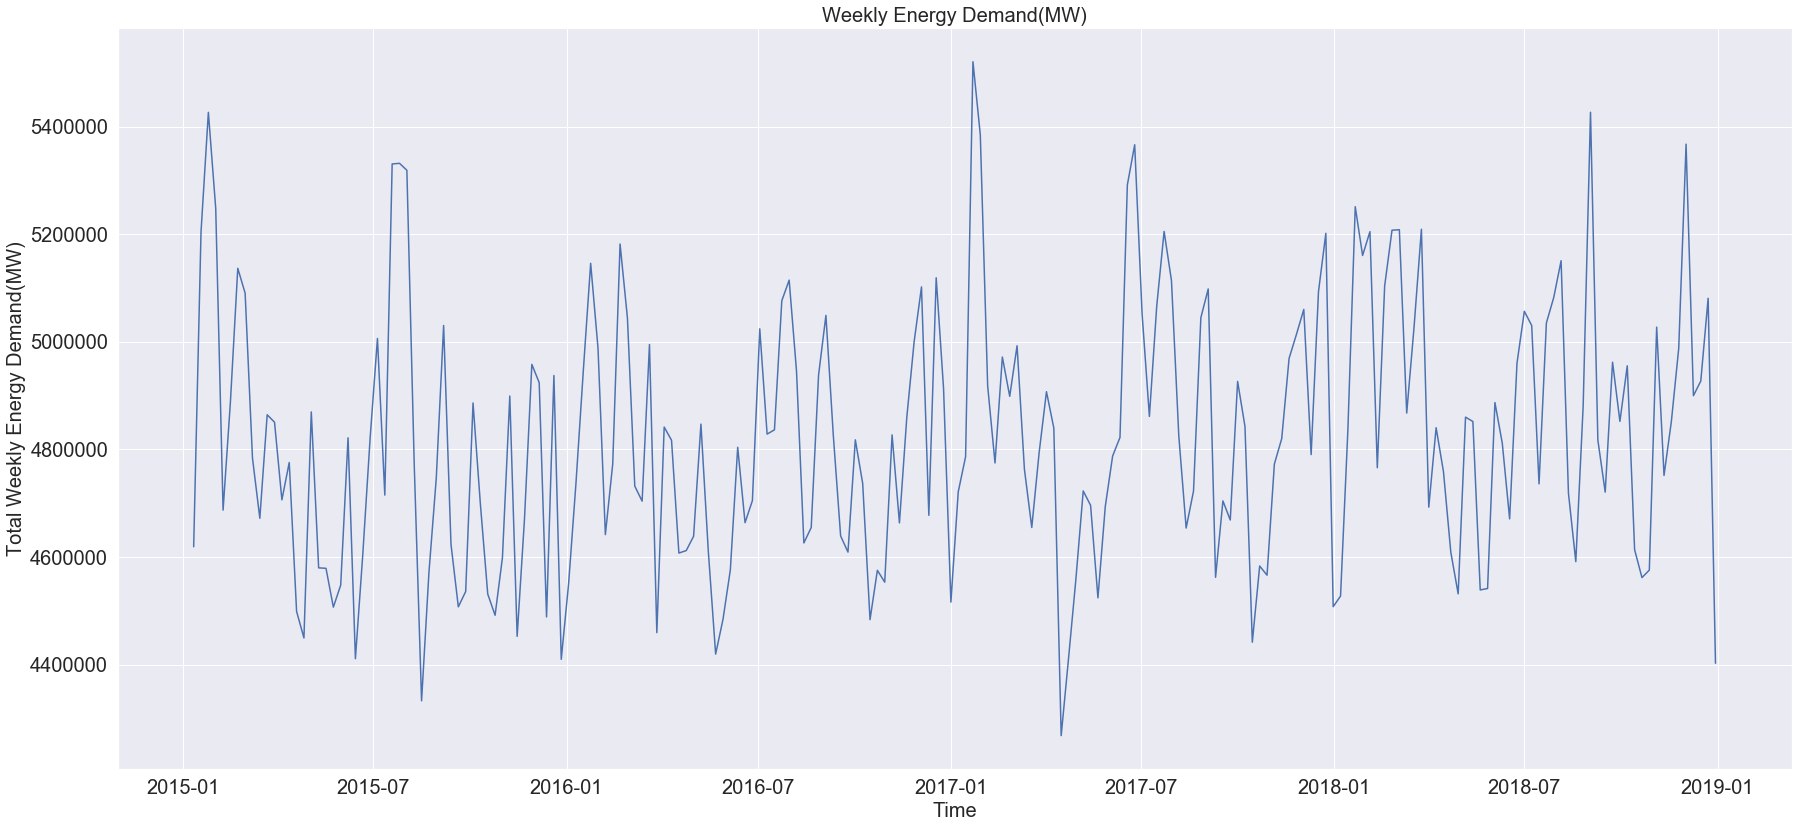

In [703]:
plt.figure(figsize=[30,30])
plt.subplot(2,1,1)
plt.plot(weekly_demand[1:-1])

plt.xlabel("Time",size=20)
plt.ylabel("Total Weekly Energy Demand(MW)",size=20)
plt.title("Weekly Energy Demand(MW)",size=20)
plt.xticks(size=20)
plt.yticks(size=20);

The dicky fuller test can let us know if the dataset is stationary or not..

In [158]:
dicky_train=adfuller(y_train)
dicky_all=adfuller(demand_actual)
print("Training set: p-value: " + str(dicky_train[1]) + " ,Test stat: "+ str(dicky_train[0]) )
print("Full data: p-value: " + str(dicky_all[1]) + " ,Test stat: "+ str(dicky_all[0]) )

Training set: p-value: 6.682482223436118e-07 ,Test stat: -5.72855849274912
Full data: p-value: 0.0 ,Test stat: -21.575901108565578


Using the Dicky-Fuller test, we see a very low p-value and highly negative test statistic meaning the dataset can be considered stationary. There is no need to transform the data. The Seasonal differncial order will be set 0.

Let's decompose the dataset to have a deeper look at the trends, seasonality and residuals

C:\Users\yfawz\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)
C:\Users\yfawz\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)
C:\Users\yfawz\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


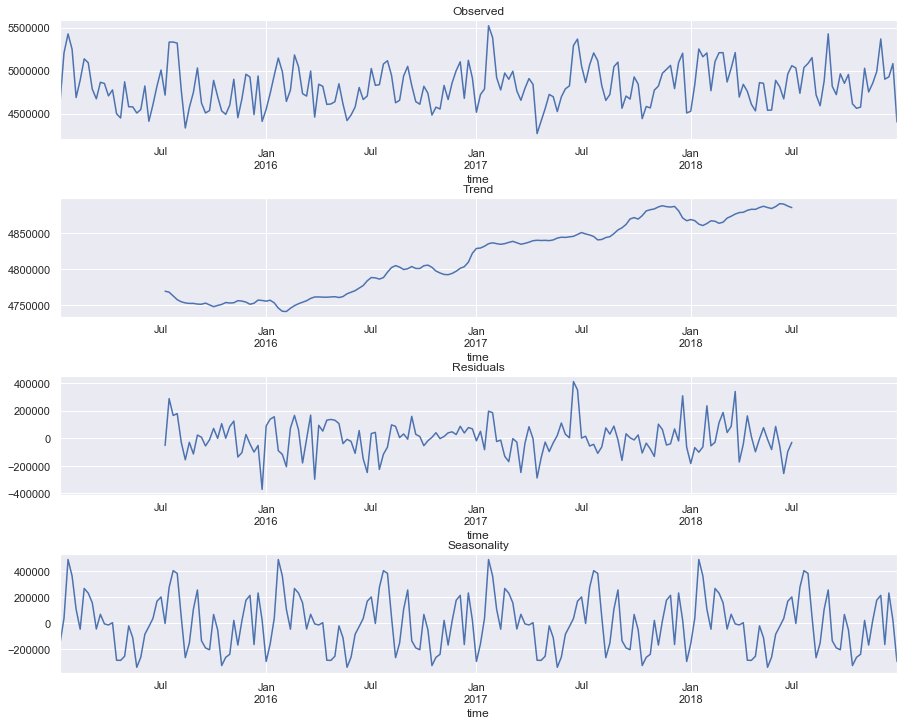

In [160]:
pd.plotting.register_matplotlib_converters()
res=seasonal_decompose(weekly_demand[1:-1], freq=52)
fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(15,12))
plt.subplots_adjust(hspace=0.5)

res.observed.plot(ax=ax1)
ax1.set_title("Observed")

res.trend.plot(ax=ax2)
ax2.set_title("Trend")

res.resid.plot(ax=ax3)
ax3.set_title("Residuals")

res.seasonal.plot(ax=ax4)
ax4.set_title("Seasonality");

The ACF and PACF can help us choose the best model parameters...

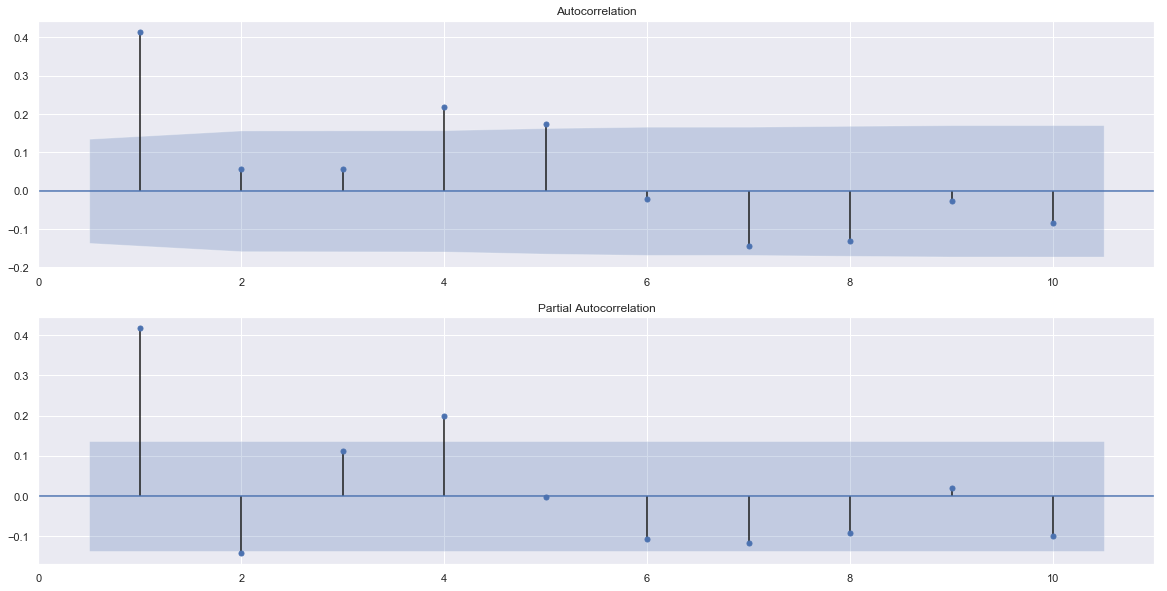

In [26]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(20,10))

plot_acf(weekly_demand, lags=10, zero=False, ax=ax1)
plot_pacf(weekly_demand, lags=10, zero=False, ax=ax2);

As can be seen ACF and PACF cut off at lag =1, this is a vague interperatation we can test differenty order parameter using Auto Arima tool

# B) Hyperparameter Tuning

In [704]:
orders=pm.auto_arima(y_train[2:], exogenous=X_train[2:],
                      seasonal=True, m=52,
                      start_d=0, start_D=0,
                      max_d=2, max_D=2,
                      start_p=2, start_q=2,
                      max_p=5, max_q=5,
                      max_P=5, max_Q=5,
                      trace=True, trend='c',
                     information_criterion='aic',
                      error_action='ignore',
                      suppress_warnings=True)

Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 0, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 52); AIC=4141.896, BIC=4208.566, Fit time=0.141 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 52); AIC=4015.829, BIC=4088.560, Fit time=3.988 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 52); AIC=4141.896, BIC=4208.566, Fit time=0.049 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 52); AIC=4038.245, BIC=4107.945, Fit time=0.192 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 0, 0, 52); AIC=4016.220, BIC=4091.981, Fit time=23.057 seconds
Near non-invertible roots for order (1, 0, 0)(2, 0, 0, 52); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.991)
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: o

In [705]:
print("The best AIC is " + str(orders.aic())) 
print("The best order is " + str(orders.order))
print("The best seasaonl order is " + str(orders.seasonal_order)) 

The best AIC is 4004.124114255688
The best order is (3, 0, 0)
The best seasaonl order is (1, 0, 0, 52)


We will select paramaters with the lowest AIC which respresents the best model for prediction.
- The parameters (3,0,0)(1,0,0,52) seem to provide the lowest AIC

Let's examine those parameters by analyze the residuals

# C) Fitting and Analyzing the Model

In [707]:
#fitting model to low AIC parameters
model_1= SARIMAX(y_train[2:], order=(3,0,0), seasonal_order=(1,0,0,52) ,exog=X_train[2:], trend='c')
result_1=model_1.fit()

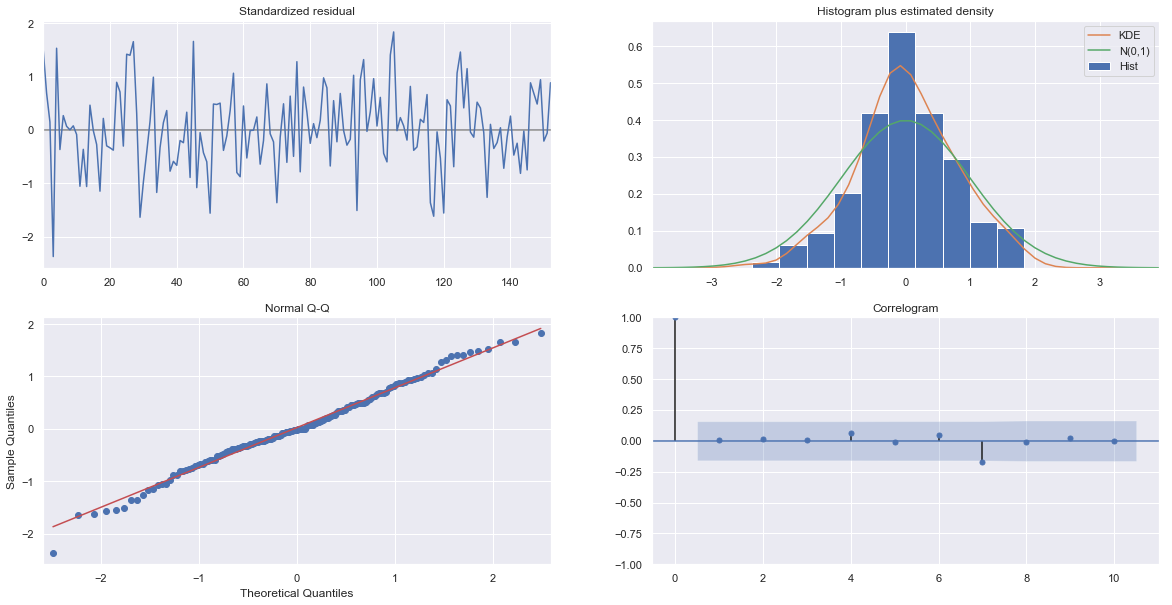

In [708]:
#plotting summary diagnostics
result_1.plot_diagnostics(figsize=[20,10]);

In [709]:
result_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  153
Model:             SARIMAX(3, 0, 0)x(1, 0, 0, 52)   Log Likelihood               -1976.062
Date:                            Fri, 21 Feb 2020   AIC                           4004.124
Time:                                    02:20:37   BIC                           4082.916
Sample:                                         0   HQIC                          4036.130
                                            - 153                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -1773.8571   5.55e+04     -0.032      0.974    -1.1e+05    1.07e+05
x1          4.025e+04   3.53e+04      1.141      0.254   -2.89e+04    1.09e+05
x2         -3.972e+04   2.04e+04     -1.949      0.051   -7.97e+04     216.816
x3          1886.6179   1.93e+04      0.098      0.922    -3.6e+04    3.98e+04
x4          5299.8296    850.509      6.231      0.000    3632.863    6966.796
x5         -4403.3185   6117.826     -0.720      0.472   -1.64e+04    7587.400
x6          1.596e+04   6618.574      2.412      0.016    2991.534    2.89e+04
x7          7.314e+05   3.34e+04     21.904      0.000    6.66e+05    7.97e+05
x8         -2.035e+05   1.19e+05     -1.707      0.088   -4.37e+05    3.02e+04
x9         -1.404e+05   1.24e+05     -1.134      0.257   -3.83e+05    1.02e+05
x10         -1.25e+06   1.02e+04   -122.052      0.000   -1.27e+06   -1.23e+06
x11         1.423e+05    2.6e+05      0.548      0.584   -3.67e+05    6.51e+05
x12         -6.81e+04   3.24e+04     -2.100      0.036   -1.32e+05   -4545.093
x13         -795.7530   2169.377     -0.367      0.714   -5047.654    3456.148
x14         1.186e+04   3.03e+04      0.392      0.695   -4.75e+04    7.12e+04
x15        -4.156e+04   1.09e+05     -0.382      0.702   -2.55e+05    1.72e+05
x16            0.9790      0.115      8.478      0.000       0.753       1.205
x17           -0.2759      0.062     -4.473      0.000      -0.397      -0.155
x18        -4.826e+04   2.09e+04     -2.307      0.021   -8.93e+04   -7252.870
x19         1.341e+04    1.1e+04      1.216      0.224   -8209.760     3.5e+04
x20         -316.1960   1.15e+04     -0.028      0.978   -2.28e+04    2.22e+04
ar.L1          1.0865      0.167      6.493      0.000       0.759       1.414
ar.L2         -0.6460      0.215     -3.007      0.003      -1.067      -0.225
ar.L3          0.3061      0.173      1.775      0.076      -0.032       0.644
ar.S.L52       0.3814      0.194      1.962      0.050       0.000       0.762
sigma2      1.382e+10      2.160    6.4e+09      0.000    1.38e+10    1.38e+10
===================================================================================
Ljung-Box (Q):                       41.40   Jarque-Bera (JB):                 0.29
Prob(Q):                              0.41   Prob(JB):                         0.87
Heteroskedasticity (H):               0.71   Skew:                            -0.09
Prob(H) (two-sided):                  0.23   Kurtosis:                         3.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.35e+25. Standard errors may be unstable.
"""

Prob(Q) is the p-value for the null hypothesis that residuals are uncorrelated. It is greater than 0.05, meaning that the residuals are indeed uncorrelated.

Prob(JB) is the p-value for the null hypothesis that residuals are normally distributed. It is greater than 0.05, meaning that the residuals are indeed normally distributed.

We can that the residuals look okay but can be improved, perhaps we can remove some features but first....

Let's visualize the training and tesing datasets further...

In [710]:
#predicting demand on training set
forecast_1=result_1.get_prediction(start=-len(X_train[2:]), exog=X_train[2:])
mean_forecast_1=forecast_1.predicted_mean

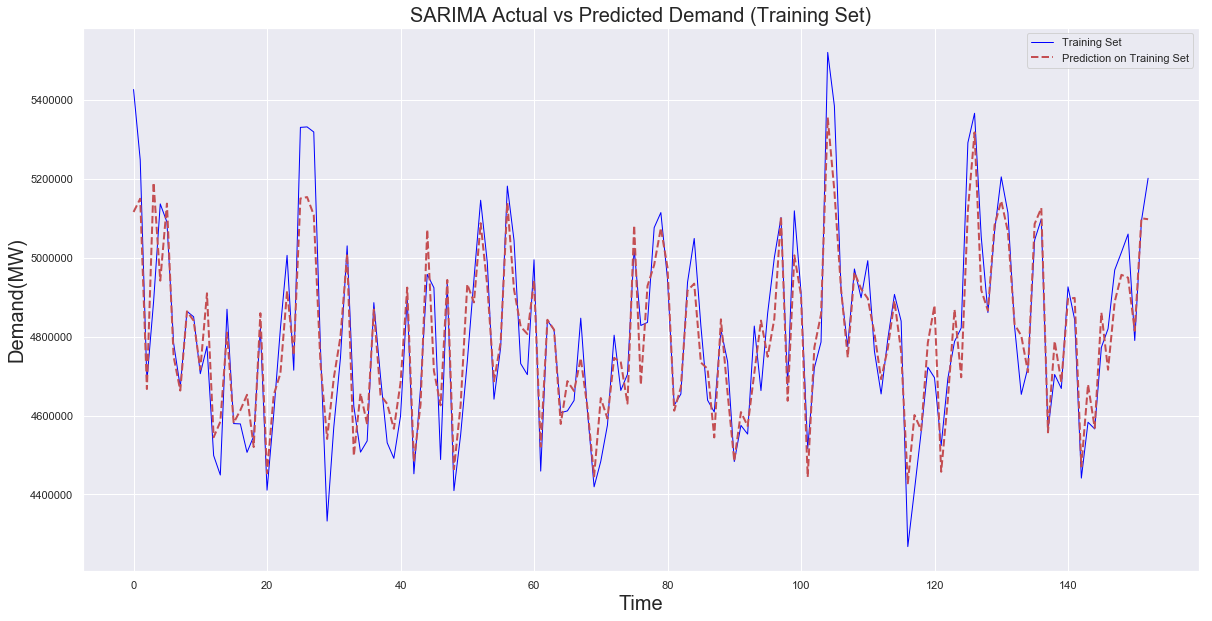

In [711]:
#plotting demand (actual predicting for test set
plt.figure(figsize=[20,10])

plt.plot(y_train[2:], linestyle="-", color='blue', linewidth=1, label='Training Set')
plt.plot(mean_forecast_1, linestyle="--", color='r', linewidth=2, label='Prediction on Training Set')

plt.title("SARIMA Actual vs Predicted Demand (Training Set)", size=20)
plt.xlabel("Time", size=20)
plt.ylabel("Demand(MW)", size=20)
plt.legend();

In [712]:
m1_score_train=np.round(np.sqrt(mean_squared_error(y_train[2:], mean_forecast_1)))
m1_score_train_mae=np.mean(np.abs(result_1.resid))
print("The RMSE for model 1(SARIMAX) is " + str(m1_score_train)  + "MW")
print("The RMSE for model 1(SARIMAX) is " + str(np.round(m1_score_train*100/np.mean(y_train),2))  + "% of the mean of the training set")

print("The MAE for model 1(SARIMAX) is " + str(m1_score_train_mae)  + "MW")
print("The MAE for model 1(SARIMAX) is " + str(np.round(m1_score_train_mae*100/np.mean(y_train),2))  + "% of the mean of the training set")

The RMSE for model 1(SARIMAX) is 95114.0MW
The RMSE for model 1(SARIMAX) is 1.98% of the mean of the training set
The MAE for model 1(SARIMAX) is 72698.41866621393MW
The MAE for model 1(SARIMAX) is 1.51% of the mean of the training set


Given that the mean is 5,000,000 MW per week, our errors are relatively small but are not perfect for the training set

We can imporove the model by removing insignifcant features

Let's reduce the features...
x1,x3,x5,x9,x13,x14,x15,x20 seem to have very large p-values...Let's try optimizing the model by using less features

In [713]:
X_opt=pd.DataFrame(data=[x2,x4,x6,x7,x8,x10,x11,x12,x16,x17,x18,x19]).T
X_train_opt=X_opt.loc[X_opt.index.year.isin([2015,2016,2017])][1:-1].values
X_test_opt=X_opt.loc[X_opt.index.year.isin([2018])][1:-1].values

Let's rerun the parameter tuning to make sure the change features do not change the best model parameters

In [714]:
orders_opt=pm.auto_arima(y_train[2:], exogenous=X_train_opt[2:],
                      seasonal=True, m=52,
                      d=0, D=0, 
                      start_p=2, start_q=2,
                      max_p=5, max_q=5,
                      max_P=5, max_Q=5,
                      trace=True, trend='c',
                     information_criterion='aic',
                      error_action='ignore',
                      suppress_warnings=True)

Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 0, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 52); AIC=4145.415, BIC=4187.841, Fit time=0.117 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 52); AIC=4002.613, BIC=4051.100, Fit time=2.635 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 52); AIC=4145.415, BIC=4187.841, Fit time=0.109 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 52); AIC=4022.269, BIC=4067.725, Fit time=0.109 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 0, 0, 52); AIC=4003.596, BIC=4055.113, Fit time=11.996 seconds
Near non-invertible roots for order (1, 0, 0)(2, 0, 0, 52); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.990)
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: o

In [715]:
print("The best AIC is " + str(orders_opt.aic())) 
print("The best order is " + str(orders_opt.order))
print("The best seasaonl order is " + str(orders_opt.seasonal_order)) 

The best AIC is 3990.4675599285497
The best order is (3, 0, 0)
The best seasaonl order is (1, 0, 0, 52)


Let's see if the model imporoved from our RMSE/MEAN of 1.98% and MAE/MEAN of 1.51%

In [716]:
#fitting model to low AIC parameters
model_2= SARIMAX(y_train[2:], order=(3,0,0), seasonal_order=(1,0,0,52) ,exog=X_train_opt[2:], trend='c')
result_2=model_2.fit()

In [717]:
result_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  153
Model:             SARIMAX(3, 0, 0)x(1, 0, 0, 52)   Log Likelihood               -1977.234
Date:                            Fri, 21 Feb 2020   AIC                           3990.468
Time:                                    02:24:08   BIC                           4045.015
Sample:                                         0   HQIC                          4012.626
                                            - 153                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -2363.7577   2.15e+05     -0.011      0.991   -4.24e+05    4.19e+05
x1          -665.7771   5865.416     -0.114      0.910   -1.22e+04    1.08e+04
x2          4611.3038   1552.771      2.970      0.003    1567.929    7654.678
x3          2.263e+04   4930.046      4.590      0.000     1.3e+04    3.23e+04
x4          4.127e+05   1.82e+05      2.261      0.024     5.5e+04     7.7e+05
x5          3715.2692   1.65e+05      0.022      0.982    -3.2e+05    3.27e+05
x6         -9.418e+05   4.35e+04    -21.659      0.000   -1.03e+06   -8.57e+05
x7         -3.636e+04   1.16e+05     -0.314      0.754   -2.64e+05    1.91e+05
x8         -9.177e+04   2.34e+04     -3.927      0.000   -1.38e+05    -4.6e+04
x9             0.9790      0.099      9.908      0.000       0.785       1.173
x10           -0.2746      0.052     -5.255      0.000      -0.377      -0.172
x11        -2.746e+04   8832.339     -3.108      0.002   -4.48e+04   -1.01e+04
x12        -3987.0086   5471.107     -0.729      0.466   -1.47e+04    6736.165
ar.L1          1.1102      0.142      7.831      0.000       0.832       1.388
ar.L2         -0.6206      0.210     -2.953      0.003      -1.033      -0.209
ar.L3          0.2742      0.178      1.542      0.123      -0.074       0.623
ar.S.L52       0.4207      0.180      2.334      0.020       0.067       0.774
sigma2      1.363e+10      1.097   1.24e+10      0.000    1.36e+10    1.36e+10
===================================================================================
Ljung-Box (Q):                       40.21   Jarque-Bera (JB):                 5.69
Prob(Q):                              0.46   Prob(JB):                         0.06
Heteroskedasticity (H):               0.71   Skew:                            -0.00
Prob(H) (two-sided):                  0.22   Kurtosis:                         3.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.71e+26. Standard errors may be unstable.
"""

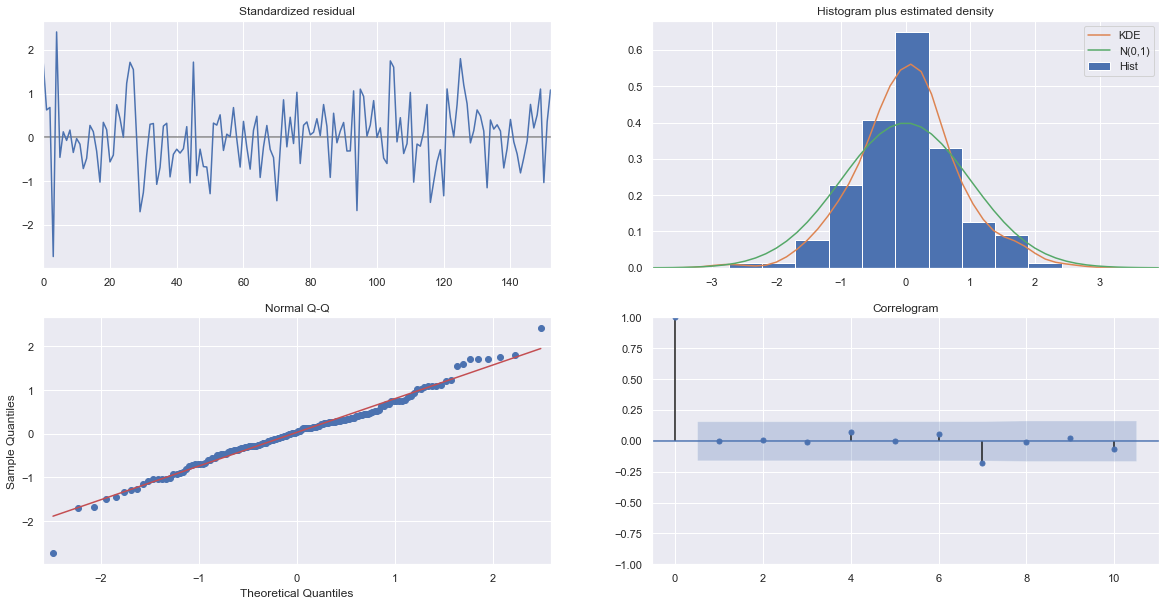

In [718]:
result_2.plot_diagnostics(figsize=[20,10]);

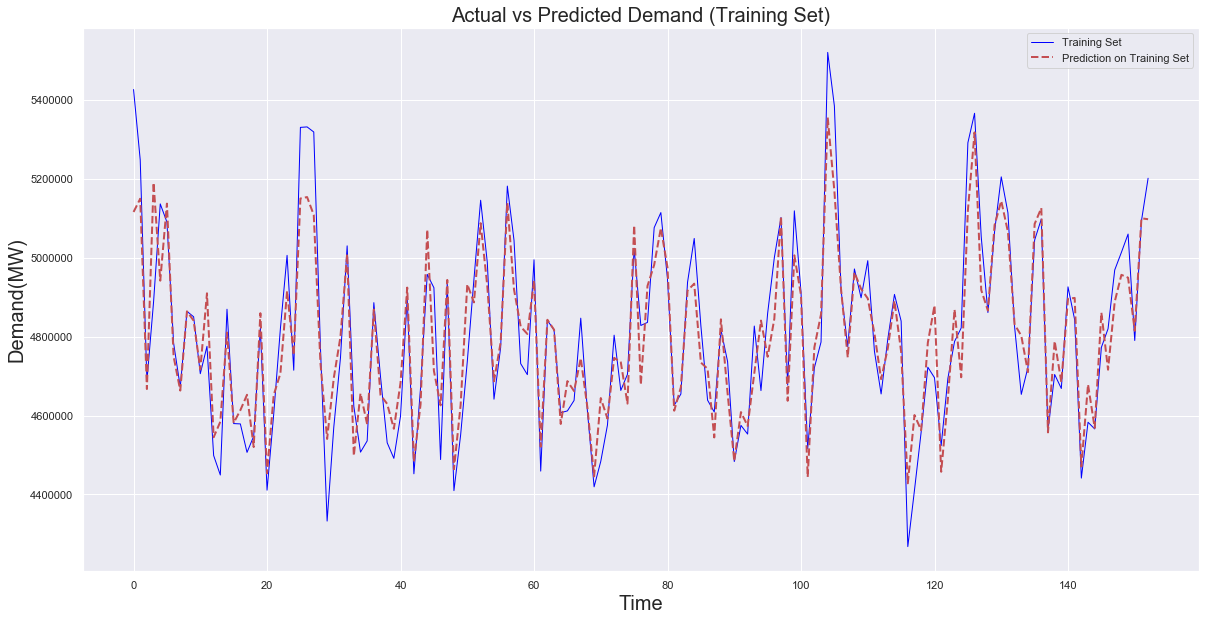

In [719]:
#predicting demand on training set
forecast_2=result_2.get_prediction(start=-len(X_train_opt[2:]), exog=X_train_opt[2:])
mean_forecast_2=forecast_2.predicted_mean

#plotting demand (actual predicting for test set
plt.figure(figsize=[20,10])

plt.plot(y_train[2:], linestyle="-", color='blue', linewidth=1, label='Training Set')
plt.plot(mean_forecast_1, linestyle="--", color='r', linewidth=2, label='Prediction on Training Set')

plt.title("Actual vs Predicted Demand (Training Set)", size=20)
plt.xlabel("Time", size=20)
plt.ylabel("Demand(MW)", size=20)
plt.legend();

In [720]:
m2_score_train=np.round(np.sqrt(mean_squared_error(y_train[2:], mean_forecast_2)))
m2_score_train_mae=np.mean(np.abs(result_2.resid))

print("The RMSE for model 1(SARIMAX) is " + str(m2_score_train)  + "MW")
print("The RMSE for model 1(SARIMAX) is " + str(np.round(m2_score_train*100/np.mean(y_train),2))  + "% of the mean of the training set")

print("The MAE for model 1(SARIMAX) is " + str(m2_score_train_mae)  + "MW")
print("The MAE for model 1(SARIMAX) is " + str(np.round(m2_score_train_mae*100/np.mean(y_train),2))  + "% of the mean of the training set")

The RMSE for model 1(SARIMAX) is 97842.0MW
The RMSE for model 1(SARIMAX) is 2.04% of the mean of the training set
The MAE for model 1(SARIMAX) is 72277.99279002125MW
The MAE for model 1(SARIMAX) is 1.5% of the mean of the training set


The 2nd Model has better results on the training set, but what about the testing set?

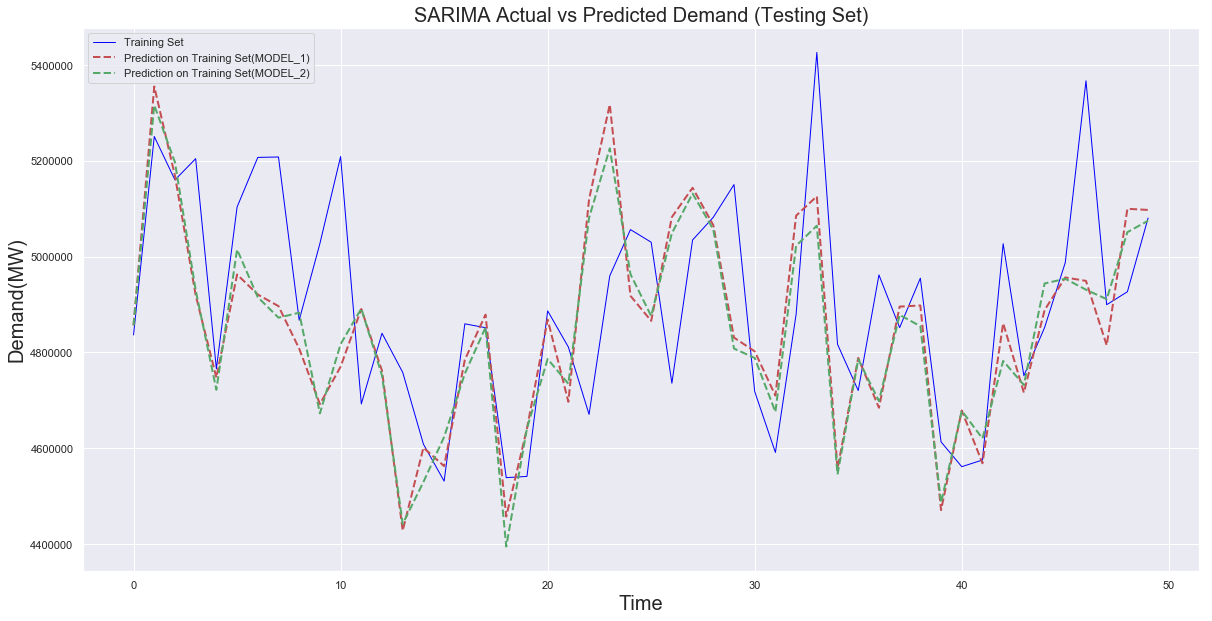

In [721]:
#predicting demand on testing set
forecast_test_1=result_1.get_prediction(start=-len(X_test_opt), exog=X_test_opt)
mean_forecast_test_1=forecast_test_1.predicted_mean

forecast_test_2=result_2.get_prediction(start=-len(X_test_opt), exog=X_test_opt)
mean_forecast_test_2=forecast_test_2.predicted_mean

#plotting demand (actual predicting for test set
plt.figure(figsize=[20,10])

plt.plot(y_test, linestyle="-", color='blue', linewidth=1, label='Training Set')
plt.plot(mean_forecast_test_1, linestyle="--", color='r', linewidth=2, label='Prediction on Training Set(MODEL_1)')
plt.plot(mean_forecast_test_2, linestyle="--", color='g', linewidth=2, label='Prediction on Training Set(MODEL_2)')

plt.title("SARIMA Actual vs Predicted Demand (Testing Set)", size=20)
plt.xlabel("Time", size=20)
plt.ylabel("Demand(MW)", size=20)
plt.legend();

In [722]:
test_score_1=np.round(np.sqrt(mean_squared_error(y_test, mean_forecast_test_1)))

print("The RMSE for model 1(SARIMAX) is " + str(test_score_1)  + "MW")
print("The RMSE for model 1(SARIMAX) is " + str(np.round(test_score_1*100/np.mean(y_test),2))  + "% of the mean of the testing set")

test_score_2=np.round(np.sqrt(mean_squared_error(y_test, mean_forecast_test_2)))

print("The RMSE for model 2(SARIMAX) is " + str(test_score_2)  + "MW")
print("The RMSE for model 2(SARIMAX) is " + str(np.round(test_score_2*100/np.mean(y_test),2))  + "% of the mean of the testing set")

The RMSE for model 1(SARIMAX) is 199365.0MW
The RMSE for model 1(SARIMAX) is 4.07% of the mean of the testing set
The RMSE for model 2(SARIMAX) is 195663.0MW
The RMSE for model 2(SARIMAX) is 3.99% of the mean of the testing set


We see that the 2nd Model has sligtly improved scores that the first one on the testing set.

In [723]:
models.loc['sarimax']['RMSE_training(MW)']=m2_score_train
models.loc['sarimax']['RMSE/mean_training(%)']=np.round(m2_score_train*100/np.mean(y_train),2)

models.loc['sarimax']['RMSE_testing(MW)']=test_score_2
models.loc['sarimax']['RMSE/mean_testing(%)']=np.round(test_score_2*100/np.mean(y_test),2)

In [815]:
sarimax_filename = 'sarimax_best_model.sav'
joblib.dump(result_1, sarimax_filename)

['sarimax_best_model.sav']

# 2. Random Forest Regression

Just for Random forest, we will tune the hyper parameters using both randomized search CV and grid search CV. RMSE will be used to compare to the mean. 
- Time Series Split will be used to cross validate the data using 5 splits
- Max features will be tested between 2 and 15.
- Max Depth will be tested between 1 and 50.
- Number of estimators(# of trees) will be tested between 100 and 800.

## A) Randomized Search Cross Validation

In [724]:
rfr=RandomForestRegressor(random_state=42)
param_dist = {
              'n_estimators': list(np.arange(100, 800, 50)),
              'max_features': list(np.arange(2,15,1)), 
              'max_depth': list(np.arange(1, 50, 1))              
            }
my_cv = TimeSeriesSplit(n_splits=5).split(X_train[2:])

In [725]:
rfr_rscv=RandomizedSearchCV(rfr, param_dist, cv=my_cv, n_iter=3000)

In [726]:
rfr_rscv.fit(X_train[2:], y_train[2:])

RandomizedSearchCV(cv=<generator object TimeSeriesSplit.split at 0x0000018E822B4B10>,
                   error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n...
                   iid='warn', n_iter=3000, n_jobs=None,
                   param_

In [727]:
rfr_rscv.best_params_

{'n_estimators': 100, 'max_features': 4, 'max_depth': 9}

In [774]:
rfr_rscv_pred=rfr_rscv.predict(X_train[2:])
rfr_rscv_score=np.round(np.sqrt(mean_squared_error(y_train[2:], rfr_rscv_pred)))
print("Training Set: RFR RMSE Crossvalidated using Randomized Gridsearch is " + str(rfr_rscv_score)  + "MW")
print("The RMSE is " + str(np.round(rfr_rscv_score*100/np.mean(y_train),2))  + "% of the mean of the training set")

Training Set: RFR RMSE Crossvalidated using Randomized Gridsearch is 76170.0MW
The RMSE is 1.59% of the mean of the training set


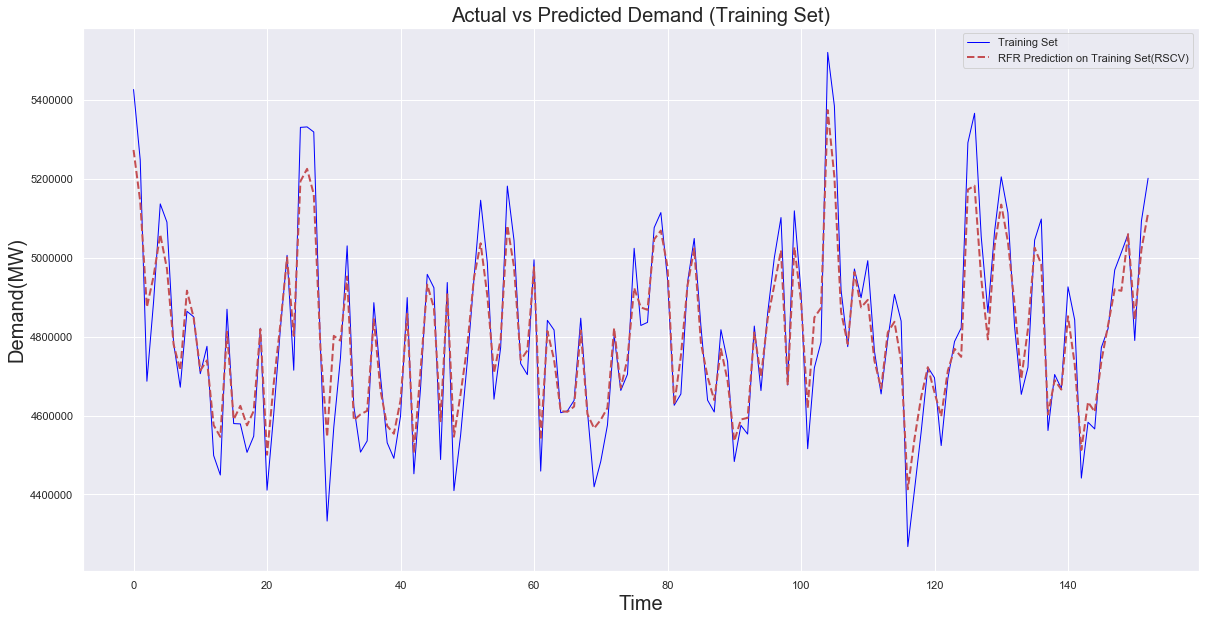

In [729]:
#plotting demand (actual predicting for test set
plt.figure(figsize=[20,10])

plt.plot(y_train[2:], linestyle="-", color='blue', linewidth=1, label='Training Set')
plt.plot(rfr_rscv_pred, linestyle="--", color='r', linewidth=2, label='RFR Prediction on Training Set(RSCV)')

plt.title("Actual vs Predicted Demand (Training Set)", size=20)
plt.xlabel("Time", size=20)
plt.ylabel("Demand(MW)", size=20)
plt.legend();

In [730]:
rfr_rscv_pred_test=rfr_rscv.predict(X_test)
rfr_rscv_score_test=np.round(np.sqrt(mean_squared_error(y_test, rfr_rscv_pred_test)))
print("The RMSE for the Random Forest Regressor Crossvalidated using Randomized gridsearch is " + str(rfr_rscv_score_test)  + "MW")
print("The RMSE is " + str(np.round(rfr_rscv_score_test*100/np.mean(y_test),2))  + "% of the mean of demand")

The RMSE for the Random Forest Regressor Crossvalidated using Randomized gridsearch is 171575.0MW
The RMSE is 3.5% of the mean of demand


This is already much better than SARIMA.

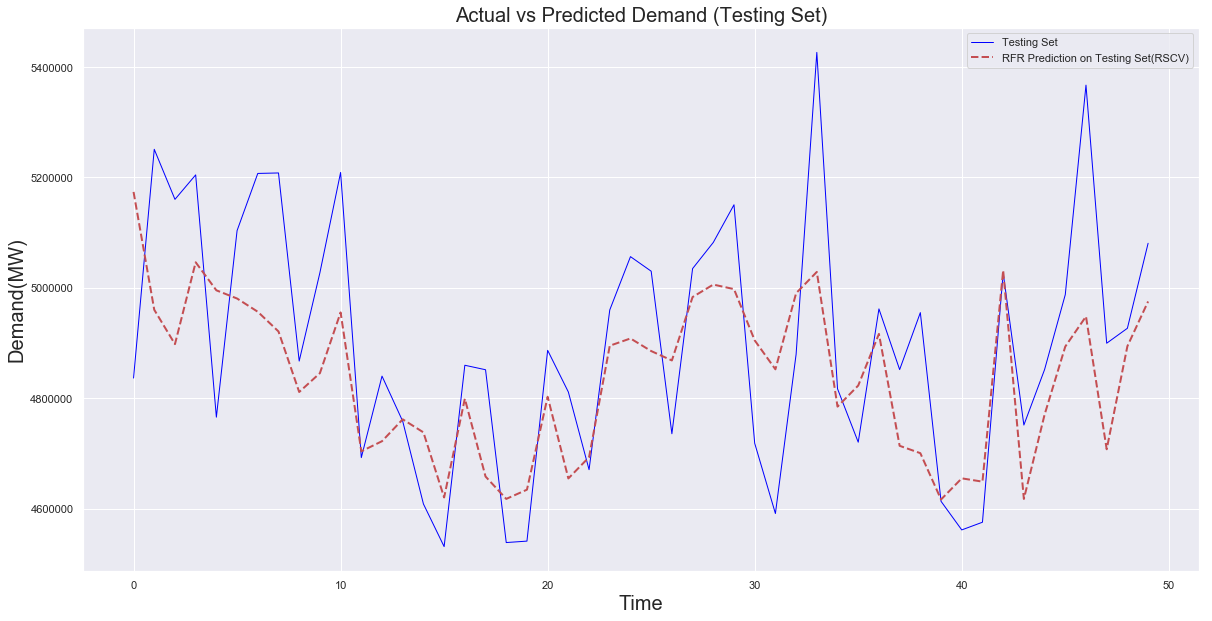

In [731]:
#plotting demand (actual predicting for test set
plt.figure(figsize=[20,10])

plt.plot(y_test, linestyle="-", color='blue', linewidth=1, label='Testing Set')
plt.plot(rfr_rscv_pred_test, linestyle="--", color='r', linewidth=2, label='RFR Prediction on Testing Set(RSCV)')

plt.title("Actual vs Predicted Demand (Testing Set)", size=20)
plt.xlabel("Time", size=20)
plt.ylabel("Demand(MW)", size=20)
plt.legend();

## B) Parameter Estimation using Grid Search CV

In [732]:
param_dist = {
              'n_estimators': list(np.arange(50, 500, 50)),
              'max_features': list(np.arange(2,15,1)), 
              'max_depth': list(np.arange(1, 70, 2))              
            }
my_cv = TimeSeriesSplit(n_splits=5).split(X_train[2:])

In [733]:
rfr_gscv=GridSearchCV(rfr,param_dist,cv=my_cv)
rfr_gscv.fit(X_train[2:],y_train[2:])

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x0000018E80F69930>,
             error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estim...
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
        

In [734]:
rfr_gscv.best_params_

{'max_depth': 7, 'max_features': 2, 'n_estimators': 50}

In [735]:
rfr_gscv_score=np.round(np.sqrt(mean_squared_error(y_train[2:], rfr_gscv.predict(X_train[2:]))))
print("The RMSE for the Random Forest Regressor Cross validated using grid search is " + str(rfr_gscv_score)  + "MW")
print("The RMSE is " + str(np.round(rfr_gscv_score*100/np.mean(y_train),2))  + "% of the mean of the training set")

The RMSE for the Random Forest Regressor Cross validated using grid search is 103196.0MW
The RMSE is 2.15% of the mean of the training set


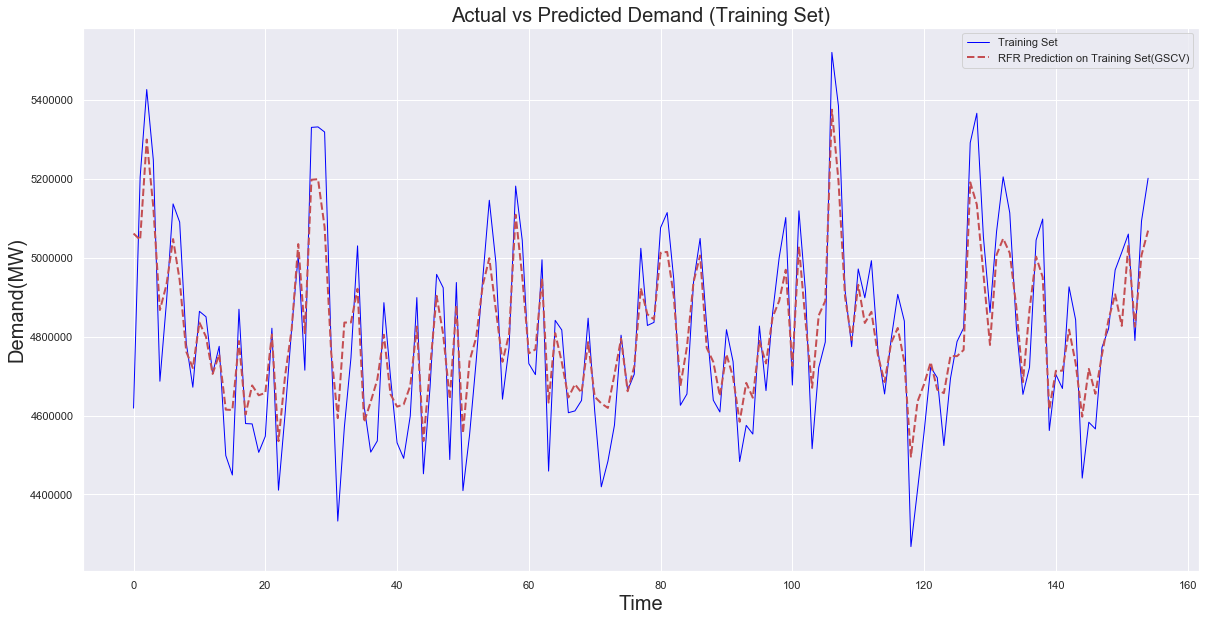

In [736]:
#plotting demand (actual predicting for test set
plt.figure(figsize=[20,10])

plt.plot(y_train, linestyle="-", color='blue', linewidth=1, label='Training Set')
plt.plot(rfr_gscv.predict(X_train), linestyle="--", color='r', linewidth=2, label='RFR Prediction on Training Set(GSCV)')

plt.title("Actual vs Predicted Demand (Training Set)", size=20)
plt.xlabel("Time", size=20)
plt.ylabel("Demand(MW)", size=20)
plt.legend();

In [737]:
rfr_gscv_score_test=np.round(np.sqrt(mean_squared_error(y_test, rfr_gscv.predict(X_test))))
print("The RMSE for the Random Forest Regressor Cross validated using grid search is " + str(rfr_gscv_score_test)  + "MW")
print("The RMSE is " + str(np.round(rfr_gscv_score_test*100/np.mean(weekly_demand),2))  + "% of the mean of the testing set")

The RMSE for the Random Forest Regressor Cross validated using grid search is 179331.0MW
The RMSE is 3.74% of the mean of the testing set


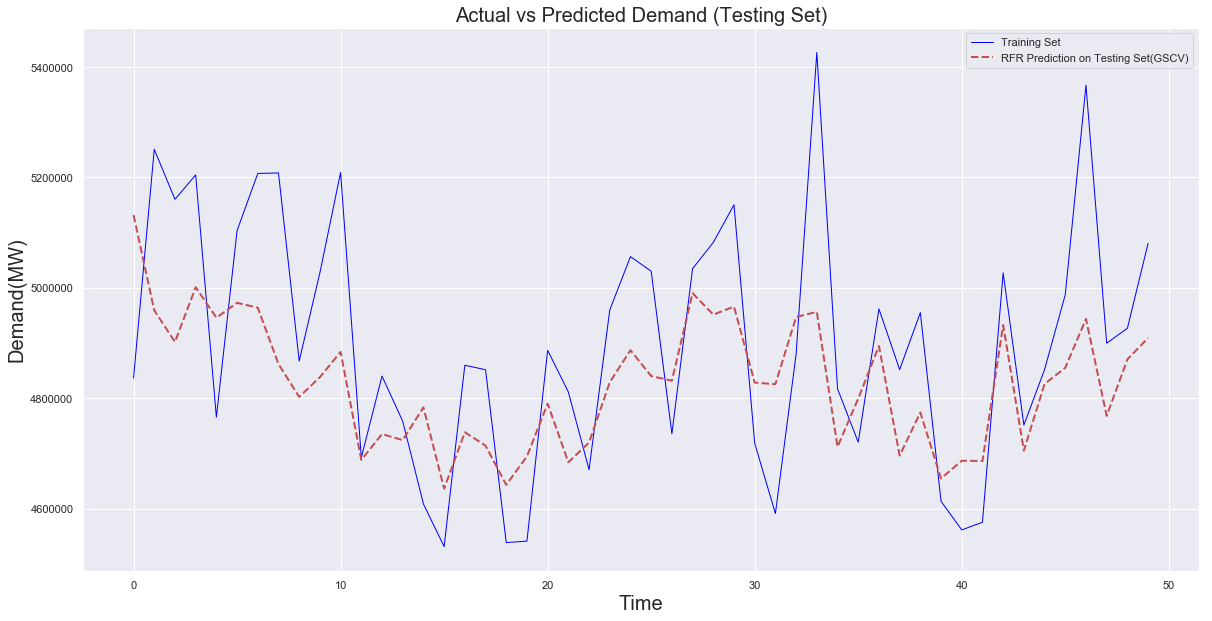

In [738]:
#plotting demand (actual predicting for test set
plt.figure(figsize=[20,10])

plt.plot(y_test, linestyle="-", color='blue', linewidth=1, label='Training Set')
plt.plot(rfr_gscv.predict(X_test), linestyle="--", color='r', linewidth=2, label='RFR Prediction on Testing Set(GSCV)')

plt.title("Actual vs Predicted Demand (Testing Set)", size=20)
plt.xlabel("Time", size=20)
plt.ylabel("Demand(MW)", size=20)
plt.legend();

## The results from the randomized search yielded the best results

This is what we can do using a random forest.
To enhance this score we can utilize gradient boosting using XGBoost and Gradient Boosting Regressor Cross Validated using Randomized Search.

Our RMSE is 171,575MW on the testing set. The required estimation are in the magintude of 5,000,000 MW. So our RMSE is 3.5% of the mean weekly demand.

In [775]:
models.loc['random_forest']['RMSE_training(MW)']=rfr_rscv_score
models.loc['random_forest']['RMSE/mean_training(%)']=np.round(rfr_rscv_score*100/np.mean(y_train),2)

models.loc['random_forest']['RMSE_testing(MW)']=rfr_rscv_score_test
models.loc['random_forest']['RMSE/mean_testing(%)']=np.round(rfr_rscv_score_test*100/np.mean(y_test),2)

In [812]:
rfr_best_model=RandomForestRegressor(
    random_state=42,
    n_estimators= 100,
    max_features= 4,
    max_depth= 9)
rfr_best_model.fit(X_train[2:],y_train[2:])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
                      max_features=4, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [816]:
rfr_filename = 'rfr_best_model.sav'
joblib.dump(rfr_best_model, rfr_filename)

['rfr_best_model.sav']

# 3. Gradient Boosting Regressor

In [740]:
gbr=GradientBoostingRegressor(criterion='mse', random_state=42)
param_dist= {
        'learning_rate': np.geomspace(0.001,0.99,50),
        'subsample': np.arange(0.1,0.9,0.1),
        'n_estimators': list(np.arange(100, 600, 50)),
        'max_depth': list(np.arange(1, 100, 3)) ,
        'max_features': list(np.arange(2,14,1)), 
}
my_cv = TimeSeriesSplit(n_splits=5).split(X_train[2:])
gbr_rscv=RandomizedSearchCV(gbr, param_dist, cv=my_cv, n_iter=3000)
gbr_rscv.fit(X_train[2:], y_train[2:])

RandomizedSearchCV(cv=<generator object TimeSeriesSplit.split at 0x0000018E822B4DE0>,
                   error_score='raise-deprecating',
                   estimator=GradientBoostingRegressor(alpha=0.9,
                                                       criterion='mse',
                                                       init=None,
                                                       learning_rate=0.1,
                                                       loss='ls', max_depth=3,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=...
                                        '

In [741]:
gbr_rscv.best_params_

{'subsample': 0.6,
 'n_estimators': 550,
 'max_features': 6,
 'max_depth': 4,
 'learning_rate': 0.21044841593281657}

In [742]:
gbr_rscv_pred=gbr_rscv.predict(X_train[2:])
gbr_rscv_score=np.round(np.sqrt(mean_squared_error(y_train[2:], gbr_rscv_pred)))
print("The RMSE for the Gradient Boosting Regressor Cross validated using Randomized search is " + str(gbr_rscv_score)  + "MW")
print("The RMSE is " + str(np.round(gbr_rscv_score*100/np.mean(y_train),2))  + "% of the mean of the training set")

The RMSE for the Gradient Boosting Regressor Cross validated using Randomized search is 0.0MW
The RMSE is 0.0% of the mean of the training set


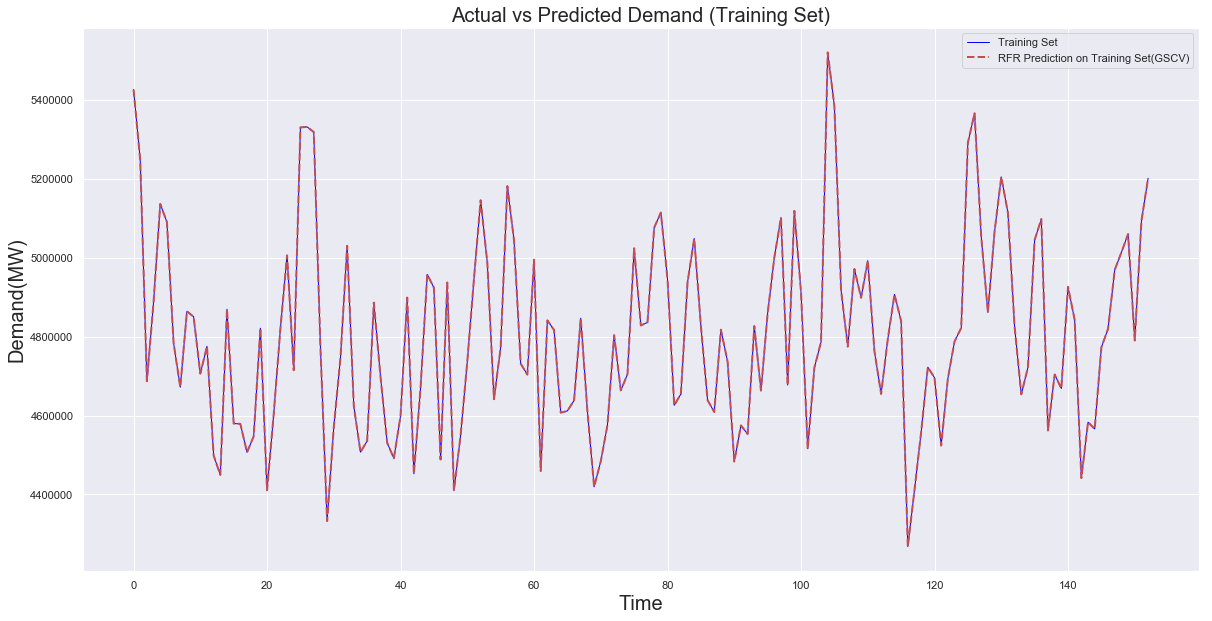

In [743]:
#plotting demand (actual predicting for test set
plt.figure(figsize=[20,10])

plt.plot(y_train[2:], linestyle="-", color='blue', linewidth=1, label='Training Set')
plt.plot(gbr_rscv_pred, linestyle="--", color='r', linewidth=2, label='RFR Prediction on Training Set(GSCV)')

plt.title("Actual vs Predicted Demand (Training Set)", size=20)
plt.xlabel("Time", size=20)
plt.ylabel("Demand(MW)", size=20)
plt.legend();

In [744]:
gbr_rscv_pred_test=gbr_rscv.predict(X_test[2:])
gbr_rscv_score_test=np.round(np.sqrt(mean_squared_error(y_test[2:], gbr_rscv_pred_test)))
print("The RMSE for the Gradient Boosting Regressor Cross validated using Randomized search is " + str(gbr_rscv_score_test)  + "MW")
print("The RMSE is " + str(np.round(gbr_rscv_score_test*100/np.mean(y_test),2))  + "% of the mean of the Testing set")

The RMSE for the Gradient Boosting Regressor Cross validated using Randomized search is 162258.0MW
The RMSE is 3.31% of the mean of the Testing set


This is an improvement from the Random Forest Regressor

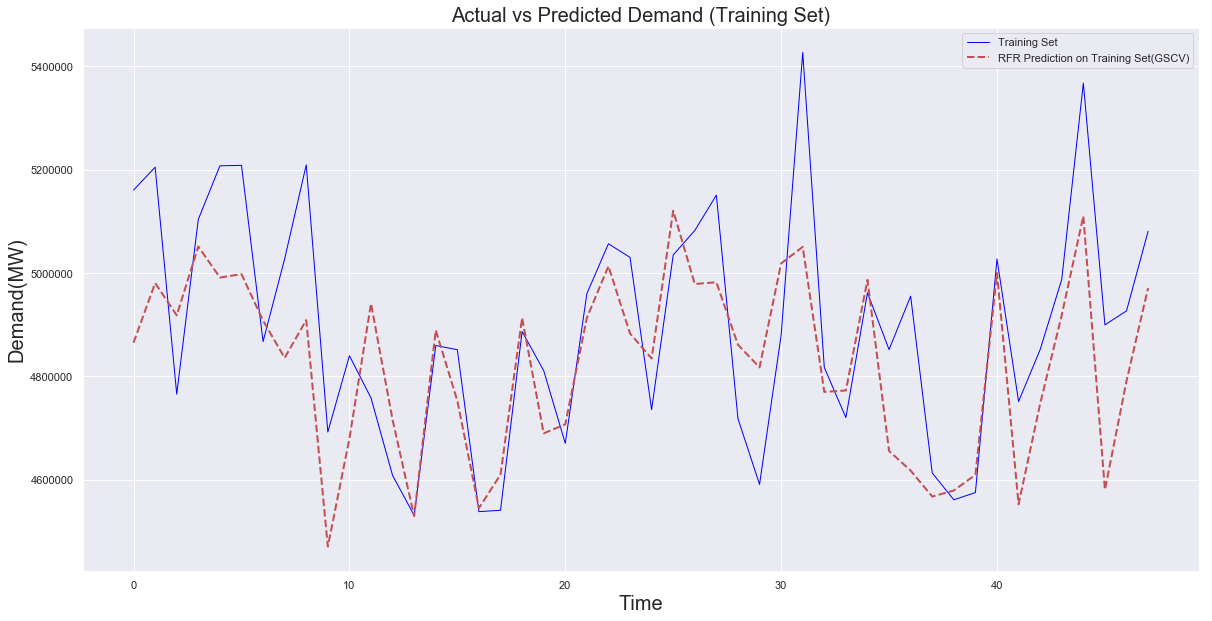

In [745]:
#plotting demand (actual predicting for test set
plt.figure(figsize=[20,10])

plt.plot(y_test[2:], linestyle="-", color='blue', linewidth=1, label='Training Set')
plt.plot(gbr_rscv_pred_test, linestyle="--", color='r', linewidth=2, label='RFR Prediction on Training Set(GSCV)')

plt.title("Actual vs Predicted Demand (Training Set)", size=20)
plt.xlabel("Time", size=20)
plt.ylabel("Demand(MW)", size=20)
plt.legend();

In [791]:
models.loc['gradient_boost']['RMSE_training(MW)']=gbr_rscv_score
models.loc['gradient_boost']['RMSE/mean_training(%)']=np.round(gbr_rscv_score*100/np.mean(y_train),2)

models.loc['gradient_boost']['RMSE_testing(MW)']=gbr_rscv_score_test
models.loc['gradient_boost']['RMSE/mean_testing(%)']=np.round(gbr_rscv_score_test*100/np.mean(y_test),2)

In [809]:
gbr_best_model=GradientBoostingRegressor(
    criterion='mse', 
    random_state=42,
    subsample= 0.6,
     n_estimators= 550,
     max_features= 6,
     max_depth= 4,
     learning_rate= 0.21044841593281657
)
gbr_best_model.fit(X_train[2:],y_train[2:])

GradientBoostingRegressor(alpha=0.9, criterion='mse', init=None,
                          learning_rate=0.21044841593281657, loss='ls',
                          max_depth=4, max_features=6, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=550,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=0.6, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [810]:
gbr_filename = 'gbr_best_model.sav'
joblib.dump(gbr_best_model, gbr_filename)

['gbr_best_model.sav']

# 4. XG Boost

In [747]:
xgb_1 = xgb.XGBRegressor(booster='gbtree',
        objective='reg:squarederror')
param_dist = {'n_estimators': list(np.arange(100, 800, 20)),
              'max_features': list(np.arange(2,15,1)),
            'max_depth': list(np.arange(10, 150, 2)), 
            "subsample":list(np.geomspace(0.001, 1, 30)),
            "learning_rate": list(np.geomspace(0.001, 1, 30)),
            "colsample_bynode": list(np.arange(0, 1, 0.05)) 
       }
my_cv = TimeSeriesSplit(n_splits=6).split(X_train[2:])

In [748]:
xgb_rscv=RandomizedSearchCV(xgb_1, param_dist, cv=my_cv, n_iter=5000)

In [749]:
xgb_rscv.fit(X_train[2:], y_train[2:])

RandomizedSearchCV(cv=<generator object TimeSeriesSplit.split at 0x0000018E806575E8>,
                   error_score='raise-deprecating',
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=1...
                                                      0.04520353656360243,
                                                      0.057361525104486784,
                                                      0.0727895384398315,
                                                      0.092367085718738

In [750]:
xgb_rscv.best_params_

{'subsample': 0.2395026619987486,
 'n_estimators': 600,
 'max_features': 14,
 'max_depth': 104,
 'learning_rate': 0.0727895384398315,
 'colsample_bynode': 0.9}

In [751]:
xgb_score=np.round(np.sqrt(mean_squared_error(y_train[2:], xgb_rscv.predict(X_train[2:]))))
print("The RMSE for the XGB Cross validated using Randomized search is " + str(xgb_score)  + "MW")
print("The RMSE is " + str(np.round(xgb_score*100/np.mean(y_train[2:]),2))  + "% of the mean of the training set")

The RMSE for the XGB Cross validated using Randomized search is 7042.0MW
The RMSE is 0.15% of the mean of the training set


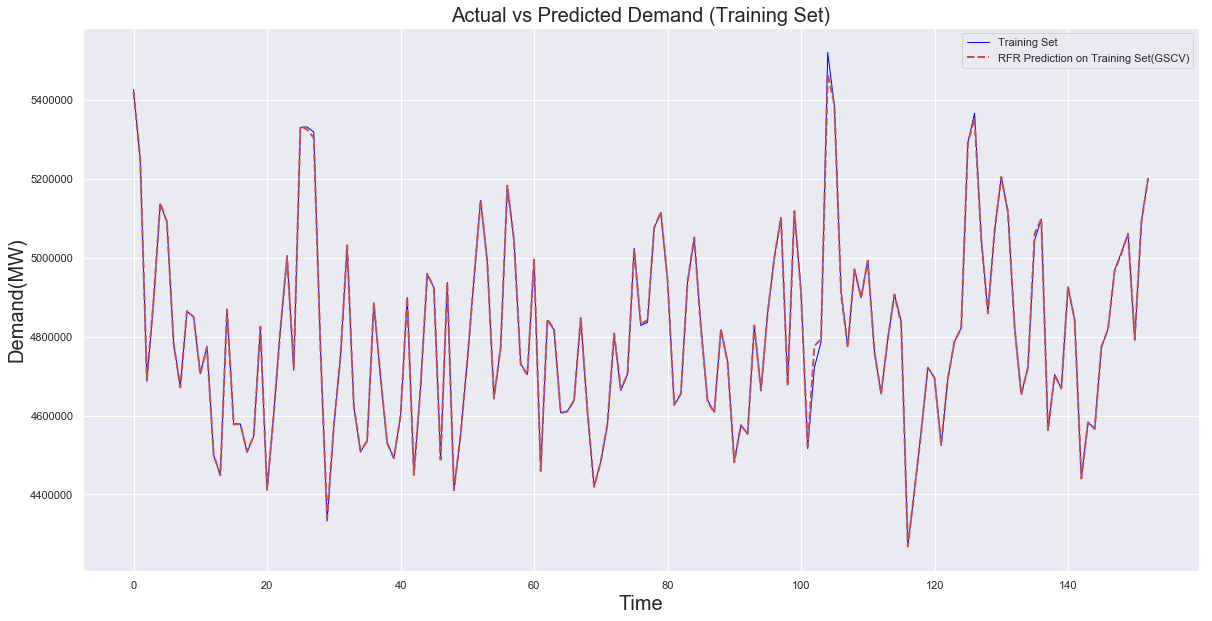

In [753]:
#plotting demand (actual predicting for test set
plt.figure(figsize=[20,10])

plt.plot(y_train[2:], linestyle="-", color='blue', linewidth=1, label='Training Set')
plt.plot(xgb_rscv.predict(X_train[2:]), linestyle="--", color='r', linewidth=2, label='RFR Prediction on Training Set(GSCV)')

plt.title("Actual vs Predicted Demand (Training Set)", size=20)
plt.xlabel("Time", size=20)
plt.ylabel("Demand(MW)", size=20)
plt.legend();

In [754]:
xgb_test=xgb_rscv.predict(X_test)
xgb_score_test=np.round(np.sqrt(mean_squared_error(y_test, xgb_rscv.predict(X_test))))
print("The RMSE for the XGB Cross validated using Randomized search is " + str(xgb_score_test)  + "MW")
print("The RMSE is " + str(np.round(xgb_score_test*100/np.mean(y_test),2))  + "% of the mean of the testing set")

The RMSE for the XGB Cross validated using Randomized search is 160784.0MW
The RMSE is 3.28% of the mean of the testing set


This is the best score of all models

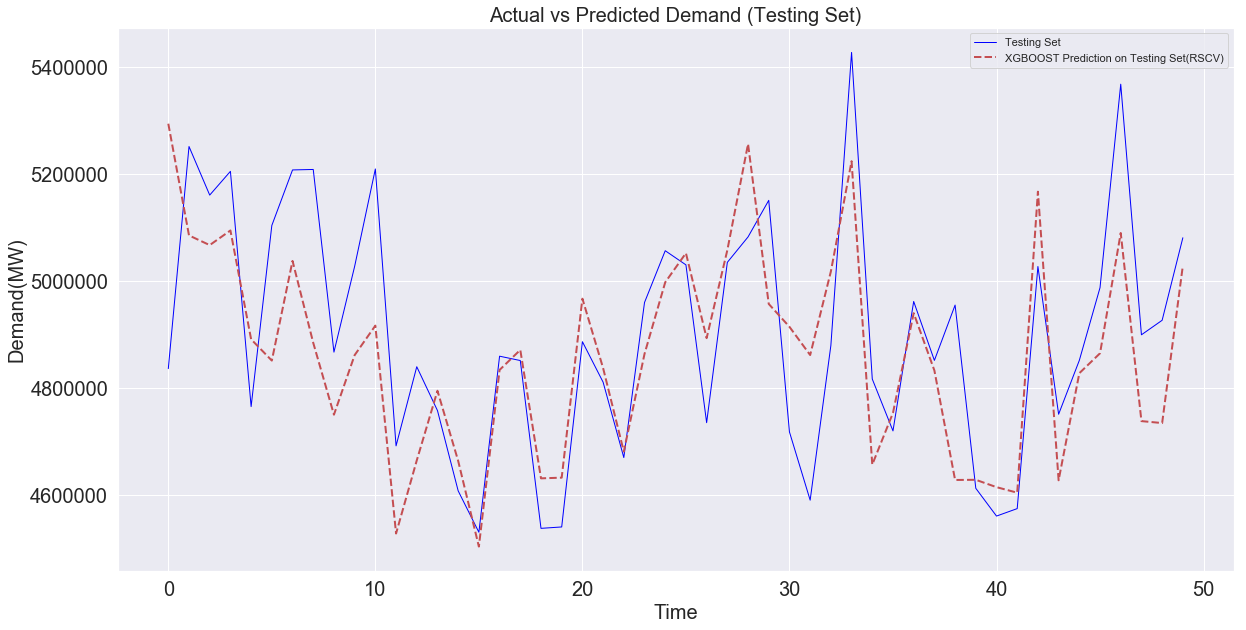

In [756]:
#plotting demand (actual predicting for test set
plt.figure(figsize=[20,10])

plt.plot(y_test, linestyle="-", color='blue', linewidth=1, label='Testing Set')
plt.plot(xgb_rscv.predict(X_test), linestyle="--", color='r', linewidth=2, label='XGBOOST Prediction on Testing Set(RSCV)')

plt.title("Actual vs Predicted Demand (Testing Set)", size=20)
plt.xlabel("Time", size=20)
plt.ylabel("Demand(MW)", size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.legend();

This model provides the best prediction compared to the others. Since XG boost provided the best score on the testing set, let's spend extra computational time by increasing the number of iterations.

In [758]:
xgb_intense = xgb.XGBRegressor(booster='gbtree',
        objective='reg:squarederror')
param_dist = {
    'n_estimators': list(np.arange(100, 1000, 25)),
              'max_features': list(np.arange(1,15,1)),
            'max_depth': list(np.arange(5, 150, 2)), 
            "subsample":list(np.geomspace(0.001, 1, 50)),
            "learning_rate": list(np.geomspace(0.001, 1, 50)),
            "colsample_bynode": list(np.arange(0, 1, 0.05)) 
       }
my_cv = TimeSeriesSplit(n_splits=6).split(X_train)

xgb_rscv_intense=RandomizedSearchCV(xgb_1, param_dist, cv=my_cv, n_iter=10000)

xgb_rscv_intense.fit(X_train, y_train)

RandomizedSearchCV(cv=<generator object TimeSeriesSplit.split at 0x0000018E81D99318>,
                   error_score='raise-deprecating',
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=1...
                                                      0.012648552168552958,
                                                      0.014563484775012436,
                                                      0.016768329368110083,
                                                      0.019306977288

In [759]:
xgb_rscv_intense.best_params_

{'subsample': 0.21209508879201905,
 'n_estimators': 875,
 'max_features': 3,
 'max_depth': 69,
 'learning_rate': 0.025595479226995357,
 'colsample_bynode': 0.2}

In [786]:
xgb_intense_score=np.round(np.sqrt(mean_squared_error(y_train[2:], xgb_rscv_intense.predict(X_train[2:]))))
print("The RMSE for the XGB Cross validated using Randomized search is " + str(xgb_score)  + "MW")
print("The RMSE is " + str(np.round(xgb_intense_score*100/np.mean(y_train[2:]),2))  + "% of the mean of the training set")

The RMSE for the XGB Cross validated using Randomized search is 7042.0MW
The RMSE is 0.44% of the mean of the training set


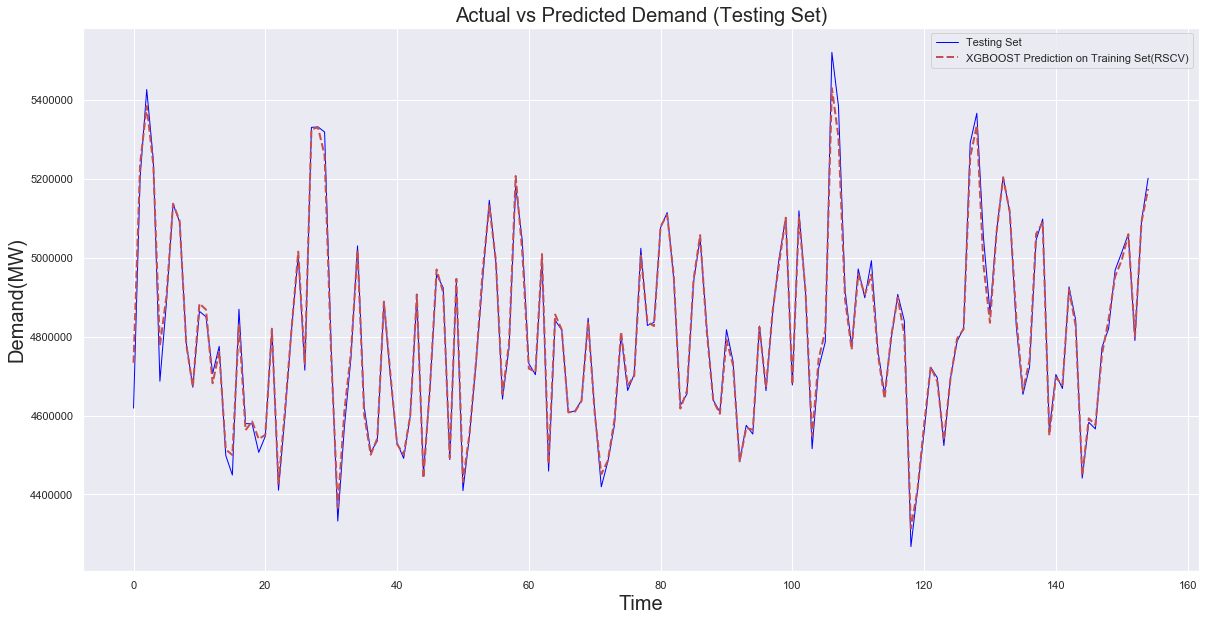

In [760]:
#plotting demand (actual predicting for test set
plt.figure(figsize=[20,10])

plt.plot(y_train, linestyle="-", color='blue', linewidth=1, label='Testing Set')
plt.plot(xgb_rscv_intense.predict(X_train), linestyle="--", color='r', linewidth=2, label='XGBOOST Prediction on Training Set(RSCV)')

plt.title("Actual vs Predicted Demand (Testing Set)", size=20)
plt.xlabel("Time", size=20)
plt.ylabel("Demand(MW)", size=20)
plt.legend();

In [761]:
xgb_test=xgb_rscv_intense.predict(X_test)
xgb_score_test=np.round(np.sqrt(mean_squared_error(y_test, xgb_rscv_intense.predict(X_test))))
print("The RMSE for the XGB Cross validated using Randomized search is " + str(xgb_score)  + "MW")
print("The RMSE is " + str(np.round(xgb_score_test*100/np.mean(y_test),2))  + "% of the mean of the testing set")

The RMSE for the XGB Cross validated using Randomized search is 7042.0MW
The RMSE is 3.02% of the mean of the testing set


We see some more imporvement

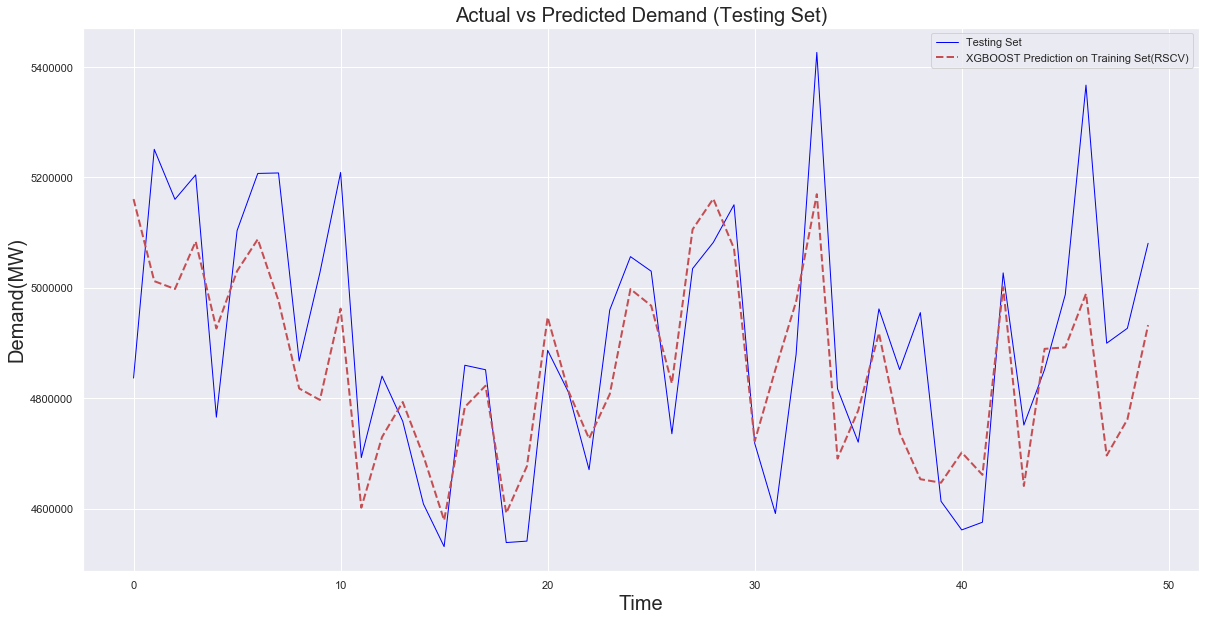

In [769]:
#plotting demand (actual predicting for test set
plt.figure(figsize=[20,10])

plt.plot(y_test, linestyle="-", color='blue', linewidth=1, label='Testing Set')
plt.plot(xgb_rscv_intense.predict(X_test), linestyle="--", color='r', linewidth=2, label='XGBOOST Prediction on Training Set(RSCV)')

plt.title("Actual vs Predicted Demand (Testing Set)", size=20)
plt.xlabel("Time", size=20)
plt.ylabel("Demand(MW)", size=20)
plt.legend();

In [789]:
models.loc['xg_boost']['RMSE_training(MW)']=xgb_intense_score
models.loc['xg_boost']['RMSE/mean_training(%)']=np.round(xgb_intense_score*100/np.mean(y_train),2)

models.loc['xg_boost']['RMSE_testing(MW)']=xgb_score_test
models.loc['xg_boost']['RMSE/mean_testing(%)']=np.round(xgb_score_test*100/np.mean(y_test),2)

In [799]:
xgb_best_model=xgb.XGBRegressor(
        booster='gbtree',
        objective='reg:squarederror',
        subsample= 0.21209508879201905,
         n_estimators=875,
         max_features= 3,
         max_depth= 69,
         learning_rate= 0.025595479226995357,
         colsample_bynode= 0.2
                         )

In [800]:
xgb_best_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=0.2, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.025595479226995357,
             max_delta_step=0, max_depth=69, max_features=3, min_child_weight=1,
             missing=None, n_estimators=875, n_jobs=1, nthread=None,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
             subsample=0.21209508879201905, verbosity=1)

In [804]:
xgb_filename = 'xgb_best_model.sav'
joblib.dump(xgb_best_model, xgb_filename)

['xgb_best_model.sav']

# 5. Conclusion

In [817]:
models

,RMSE_training(MW),RMSE/mean_training(%),RMSE_testing(MW),RMSE/mean_testing(%)
best_model,,,,
sarimax,97842.0,2.04,195663.0,3.99
random_forest,76170.0,1.59,171575.0,3.50
gradient_boost,0.0,0.00,162258.0,3.31
xg_boost,21359.0,0.44,147931.0,3.02


We can see that Gradient Booster has the best results on the training set with an RMSE of 0MW but XG Boost has the best results on the testing set an RMSE of 147,931 MW